In [1]:
import pandas as pd
import os

# 데이터 디렉토리
data_dir = "/home/jovyan/work/data"

all_data = []

# 각 테이블에서 데이터 추출
tables = [
    ('accounts_blockrecord_processed.csv', 'user_id'),
    ('accounts_failpaymenthistory.csv', 'user_id'),
    ('accounts_paymenthistory.csv', 'user_id'),
    ('accounts_pointhistory.csv', 'user_id'),
    ('accounts_timelinereport.csv', 'user_id'),
    ('accounts_user_processed.csv', 'id'),  # id가 user_id 역할
    ('accounts_userquestionrecord_processed.csv', 'user_id'),
    ('event_receipts.csv', 'user_id'),
    ('polls_questionreport.csv', 'user_id'),
    ('polls_questionset.csv', 'user_id')
]

# 일반 테이블들 처리
for file_name, user_col in tables:
    df = pd.read_csv(os.path.join(data_dir, file_name))
    temp_df = df[[user_col, 'created_at']].copy()
    temp_df.columns = ['user_id', 'created_at']
    temp_df['table_name'] = file_name.replace('.csv', '')
    all_data.append(temp_df)

# 친구 요청 테이블 - 보낸 사람만 포함 (능동적 활동)
df_friend = pd.read_csv(os.path.join(data_dir, 'accounts_friendrequest.csv'))

# 보낸 사람만 (능동적 활동)
temp_send = df_friend[['send_user_id', 'created_at']].copy()
temp_send.columns = ['user_id', 'created_at']
temp_send['table_name'] = 'accounts_friendrequest_send'
all_data.append(temp_send)

# 모든 데이터 병합
merged_df = pd.concat(all_data, ignore_index=True)

# created_at을 datetime으로 변환
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], format='ISO8601', errors='coerce')

# null 값 제거
merged_df = merged_df.dropna(subset=['created_at'])

# user_id로 그룹화하고 created_at으로 정렬
merged_df = merged_df.sort_values(['user_id', 'created_at']).reset_index(drop=True)

print(f"총 {len(merged_df):,}개 레코드 병합 완료")
print(f"유니크 사용자 수: {merged_df['user_id'].nunique():,}")
print("\n테이블별 레코드 수:")
print(merged_df['table_name'].value_counts())

총 21,705,813개 레코드 병합 완료
유니크 사용자 수: 677,085

테이블별 레코드 수:
table_name
accounts_friendrequest_send              17147175
accounts_pointhistory                     2338918
accounts_userquestionrecord_processed     1217558
accounts_user_processed                    677085
polls_questionset                          158384
accounts_paymenthistory                     95140
polls_questionreport                        51424
accounts_blockrecord_processed              19449
event_receipts                                309
accounts_timelinereport                       208
accounts_failpaymenthistory                   163
Name: count, dtype: int64


In [2]:
# 사용자별 생존기간 계산
user_survival = merged_df.groupby('user_id').agg({
    'created_at': ['first', 'last', 'count']
}).reset_index()

# 컬럼명 정리
user_survival.columns = ['user_id', 'first_activity', 'last_activity', 'total_events']

print(f"사용자 생존기간 테이블 완성: {len(user_survival):,}명")
print(user_survival.head())

# 생존일 수 계산 (차이 in days)
user_survival['survival_days'] = (user_survival['last_activity'] - user_survival['first_activity']).dt.days

# 이탈 유저 (당일 유저): 1, 잔존 유저: 0
user_survival['is_churn'] = user_survival['survival_days'].apply(lambda x: 1 if x == 0 else 0)

print(user_survival['is_churn'].value_counts())
# 1: 이탈 (하루만 활동), 0: 잔존

사용자 생존기간 테이블 완성: 677,085명
   user_id             first_activity              last_activity  total_events
0   831956 2023-03-29 03:44:14.047130 2023-03-29 03:44:14.047130             1
1   831962 2023-03-29 05:18:56.162368 2023-07-13 07:51:59.000000             2
2   832151 2023-03-29 12:56:34.989468 2023-05-09 15:50:58.000000            11
3   832340 2023-03-29 12:56:35.020790 2023-05-11 00:51:26.000000            29
4   832520 2023-03-29 12:56:35.049311 2023-03-29 12:56:35.049311             1
is_churn
0    441629
1    235456
Name: count, dtype: int64


In [4]:
user_df = pd.read_csv(os.path.join(data_dir, 'accounts_user_processed.csv'), parse_dates=['created_at'])


In [5]:
# 가입시각 정보 추출
# created_at에서 시간 파생 변수 생성
user_df['created_at'] = pd.to_datetime(user_df['created_at'], errors='coerce')
user_df['signup_month'] = user_df['created_at'].dt.month
user_df['signup_weekday'] = user_df['created_at'].dt.dayofweek  # 0: 월요일
user_df['signup_hour'] = user_df['created_at'].dt.hour


In [6]:
# user_id 형식 맞추기 (정수형 또는 문자열 확인 후)
user_df['user_id'] = user_df['id'].astype(str)
user_survival['user_id'] = user_survival['user_id'].astype(str)

# 이탈 여부 병합
user_df = pd.merge(user_df, user_survival[['user_id', 'is_churn']], on='user_id', how='left')


In [7]:
# 날짜 기준으로 학기 시작 여부 (3월/9월 1~7일)
user_df['is_semester_start_strict'] = user_df['created_at'].apply(
    lambda x: 1 if (x.month in [3, 9]) and (x.day <= 7) else 0
)


In [9]:
# 가입 시점 기준 컬럼 생성
user_survival['signup_month'] = user_survival['first_activity'].dt.month  # 가입 월
user_survival['signup_weekday'] = user_survival['first_activity'].dt.weekday  # 가입 요일 (0=월, 6=일)
user_survival['signup_hour'] = user_survival['first_activity'].dt.hour  # 가입 시간

# 학기 시작 여부: 3월/9월 1~7일이면 학기 시작 기간으로 간주
def is_semester_start(date):
    return int((date.month in [3, 9]) and (1 <= date.day <= 7))

user_survival['is_semester_start_strict'] = user_survival['first_activity'].apply(is_semester_start)

# 결과 미리보기
print(user_survival[['user_id', 'first_activity', 'signup_month', 'signup_weekday', 'signup_hour', 'is_semester_start_strict']].head())


  user_id             first_activity  signup_month  signup_weekday  \
0  831956 2023-03-29 03:44:14.047130             3               2   
1  831962 2023-03-29 05:18:56.162368             3               2   
2  832151 2023-03-29 12:56:34.989468             3               2   
3  832340 2023-03-29 12:56:35.020790             3               2   
4  832520 2023-03-29 12:56:35.049311             3               2   

   signup_hour  is_semester_start_strict  
0            3                         0  
1            5                         0  
2           12                         0  
3           12                         0  
4           12                         0  


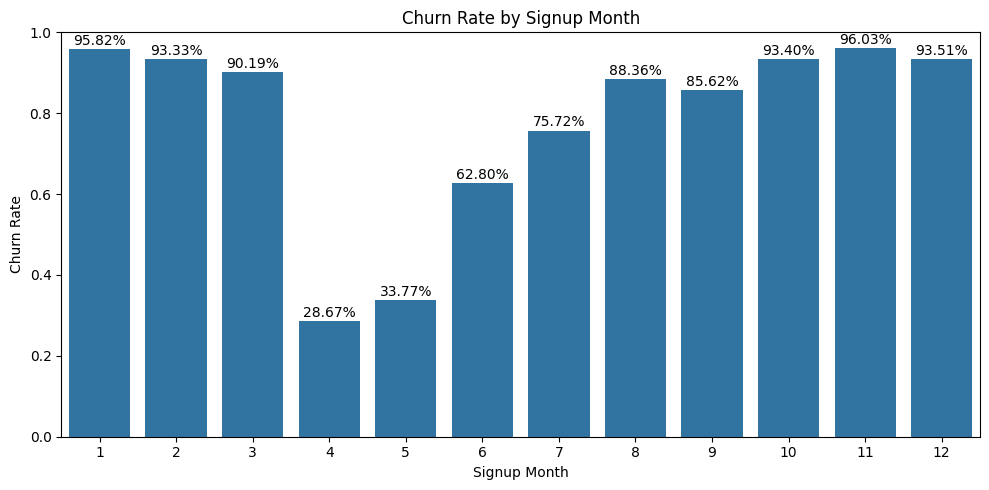

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 가입 월별 이탈률 계산
churn_by_month = user_survival.groupby('signup_month')['is_churn'].mean()

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=churn_by_month.index, y=churn_by_month.values)
plt.title('Churn Rate by Signup Month')  # 가입 월에 따른 이탈률
plt.xlabel('Signup Month')  # 가입 월
plt.ylabel('Churn Rate')  # 이탈률

# 비율 수치 표시
for i, val in enumerate(churn_by_month.values):
    plt.text(i, val + 0.01, f'{val:.2%}', ha='center')

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [24]:
from scipy.stats import chi2_contingency

# 교차표 생성
ct_month = pd.crosstab(user_survival['signup_month'], user_survival['is_churn'])

# 카이제곱 검정
chi2, p, dof, expected = chi2_contingency(ct_month)

print(f'📊 카이제곱 검정 결과(가입 월)')
print(f'χ² 통계량: {chi2:.2f}')
print(f'p-value: {p:.10f}')


📊 카이제곱 검정 결과(가입 월)
χ² 통계량: 13072.90
p-value: 0.0000000000


In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA 준비: 이탈 여부를 종속변수로, 가입 월을 범주형 독립변수로
model = ols('is_churn ~ C(signup_month)', data=user_survival).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print('\n📈 일원분산분석(ANOVA) 결과:')
print(anova_table)



📈 일원분산분석(ANOVA) 결과:
                        sum_sq        df            F  PR(>F)
C(signup_month)    2965.193543      11.0  1211.822202     0.0
Residual         150611.089824  677073.0          NaN     NaN


일별(요일)

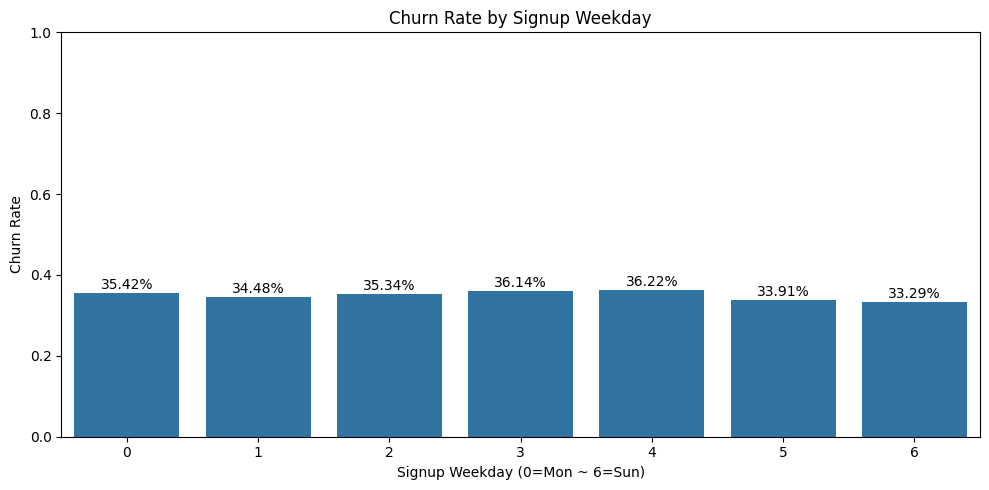

📊 카이제곱 검정 (가입 요일)
χ² 통계량: 312.96
p-value: 0.0000000000

📈 일원분산분석(ANOVA) 결과:
                          sum_sq        df          F        PR(>F)
C(signup_weekday)      70.985651       6.0  52.183674  1.317961e-64
Residual           153505.297717  677078.0        NaN           NaN


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 요일별 이탈률 계산 (0 = 월, 6 = 일)
weekday_churn = user_survival.groupby('signup_weekday')['is_churn'].mean()

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_churn.index, y=weekday_churn.values)
plt.title('Churn Rate by Signup Weekday')  # 가입 요일별 이탈률
plt.xlabel('Signup Weekday (0=Mon ~ 6=Sun)')  # 요일
plt.ylabel('Churn Rate')  # 이탈률

for i, val in enumerate(weekday_churn.values):
    plt.text(i, val + 0.01, f'{val:.2%}', ha='center')

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 📊 카이제곱 검정
ct_weekday = pd.crosstab(user_survival['signup_weekday'], user_survival['is_churn'])
chi2, p_chi2, _, _ = chi2_contingency(ct_weekday)

print('📊 카이제곱 검정 (가입 요일)')
print(f'χ² 통계량: {chi2:.2f}')
print(f'p-value: {p_chi2:.10f}')

# 📈 ANOVA
model = ols('is_churn ~ C(signup_weekday)', data=user_survival).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print('\n📈 일원분산분석(ANOVA) 결과:')
print(anova_table)


In [19]:
weekday_churn = user_survival.groupby('signup_weekday')['is_churn'].mean()
print(weekday_churn.apply(lambda x: f'{x:.2%}'))


signup_weekday
0    35.42%
1    34.48%
2    35.34%
3    36.14%
4    36.22%
5    33.91%
6    33.29%
Name: is_churn, dtype: object


가입 시간 별(이탈)

In [21]:

from scipy.stats import chi2_contingency

# 시간별 이탈 여부 교차표
ct_hour = pd.crosstab(user_survival['signup_hour'], user_survival['is_churn'])

# 카이제곱 검정
chi2_stat, p_val, _, _ = chi2_contingency(ct_hour)

print('📊 카이제곱 검정 (가입 시간)')
print(f'χ² 통계량: {chi2_stat:.2f}')
print(f'p-value: {p_val:.10f}')


📊 카이제곱 검정 (가입 시간)
χ² 통계량: 506.24
p-value: 0.0000000000


In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA 모델
anova_model = ols('is_churn ~ C(signup_hour)', data=user_survival).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print('\n📈 일원분산분석(ANOVA) 결과:')
print(anova_table)



📈 일원분산분석(ANOVA) 결과:
                       sum_sq        df         F        PR(>F)
C(signup_hour)     114.825292      23.0  22.02613  1.628381e-92
Residual        153461.458076  677061.0       NaN           NaN


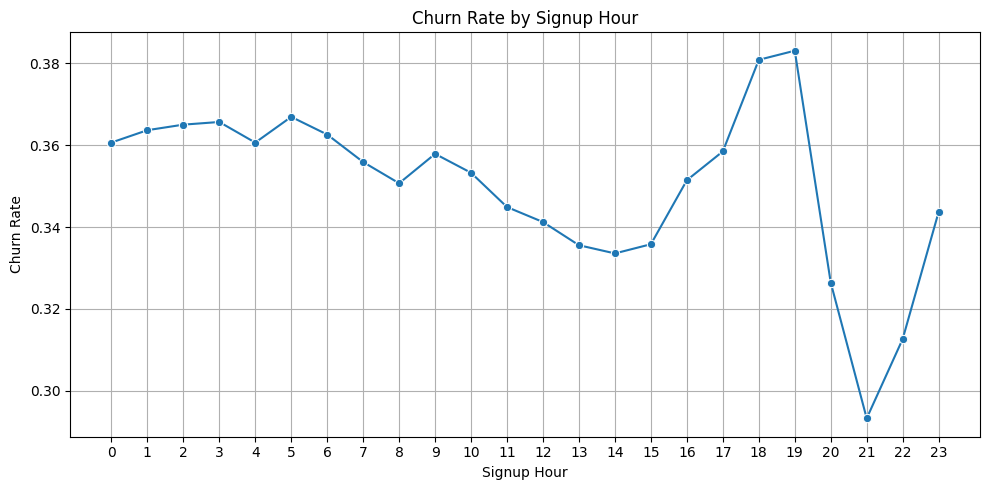

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시간대별 평균 이탈률 계산
hourly_churn = user_survival.groupby('signup_hour')['is_churn'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_churn.index, y=hourly_churn.values, marker='o')

plt.title('Churn Rate by Signup Hour')  # 가입 시간대별 이탈률
plt.xlabel('Signup Hour')
plt.ylabel('Churn Rate')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


시간대별 가입자수 비율

In [ ]:
# 시간별 가입자 수 계산
signup_hour_counts = user_survival['signup_hour'].value_counts().sort_index()

# 비율 계산
signup_hour_ratio = (signup_hour_counts / signup_hour_counts.sum() * 100).round(2)

# 결과 출력
hourly_distribution = pd.DataFrame({
    '가입자 수': signup_hour_counts,
    '비율(%)': signup_hour_ratio
})

print(hourly_distribution)


             가입자 수  비율(%)
signup_hour              
0            14526   2.15
1            17177   2.54
2            19976   2.95
3            24075   3.56
4            24101   3.56
5            23685   3.50
6            29772   4.40
7            37289   5.51
8            38369   5.67
9            38492   5.68
10           41442   6.12
11           48552   7.17
12           61300   9.05
13           72719  10.74
14           69267  10.23
15           44759   6.61
16           19411   2.87
17            6240   0.92
18            2229   0.33
19            1078   0.16
20            1060   0.16
21            3482   0.51
22           13576   2.01
23           24508   3.62


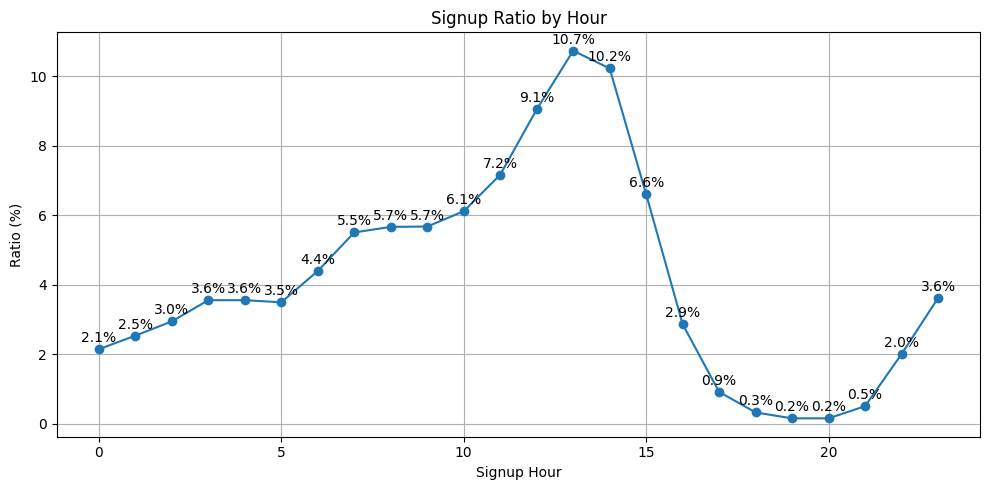

In [26]:
import matplotlib.pyplot as plt

# 시각화: 가입 시간대별 비율 라인 그래프
plt.figure(figsize=(10, 5))
plt.plot(hourly_distribution.index, hourly_distribution['비율(%)'], marker='o')

plt.title('Signup Ratio by Hour')  # 가입 시간대별 비율
plt.xlabel('Signup Hour')          # 가입 시각
plt.ylabel('Ratio (%)')            # 비율

# 각 포인트에 비율 표시
for i, val in enumerate(hourly_distribution['비율(%)']):
    plt.text(hourly_distribution.index[i], val + 0.2, f'{val:.1f}%', ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:               is_churn   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     295.1
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           4.02e-66
Time:                        19:30:12   Log-Likelihood:            -4.5833e+05
No. Observations:              677085   AIC:                         9.167e+05
Df Residuals:                  677083   BIC:                         9.167e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3678      0.001    282.787      

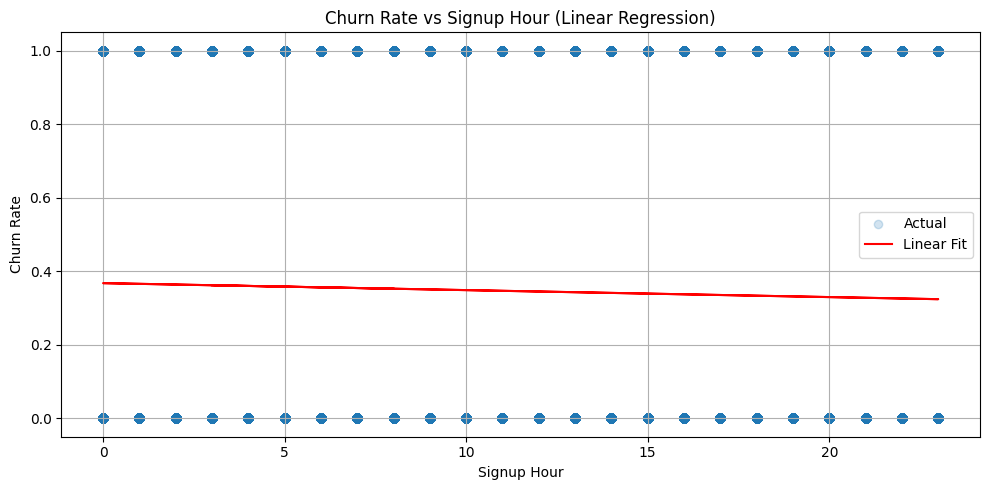

: 

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 독립 변수와 종속 변수 설정
X = sm.add_constant(user_survival['signup_hour'])  # 절편 포함
y = user_survival['is_churn']  # 종속 변수: 이탈 여부

# 선형 회귀 모델 학습
model = sm.OLS(y, X).fit()

# 회귀 결과 출력
print(model.summary())

# 예측값 계산
user_survival['predicted_churn'] = model.predict(X)

# 시각화
plt.figure(figsize=(10, 5))
plt.scatter(user_survival['signup_hour'], user_survival['is_churn'], alpha=0.2, label='Actual')
plt.plot(user_survival['signup_hour'], user_survival['predicted_churn'], color='red', label='Linear Fit')

plt.title('Churn Rate vs Signup Hour (Linear Regression)')
plt.xlabel('Signup Hour')
plt.ylabel('Churn Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
